   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.7/252.7 MB 42.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 40.6 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 36.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.4/670.4 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 39.4 MB/s eta 0:00:00
Epoch 1/50


/opt/anaconda3/envs/SEN122A/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 259480.7812 - mae: 345.2231 - val_loss: 255543.9531 - val_mae: 338.0160
Epoch 2/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 256702.1875 - mae: 306.6713 - val_loss: 172420.7344 - val_mae: 245.6703
Epoch 3/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 184970.9531 - mae: 234.3089 - val_loss: 144285.2812 - val_mae: 233.0707
Epoch 4/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 124153.6250 - mae: 223.0429 - val_loss: 141700.3438 - val_mae: 233.9093
Epoch 5/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 130546.6641 - mae: 223.4859 - val_loss: 141415.0312 - val_mae: 232.7748
Epoch 6/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 163118.8750 - mae: 230.5514 - val_loss: 141075.4219 - val_mae: 232.6744
Epoch 7/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 125522.0078 - mae: 220.2081 - val_loss: 141048.7656 - val_mae: 231.9426
Epoch 8/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 155567.5156

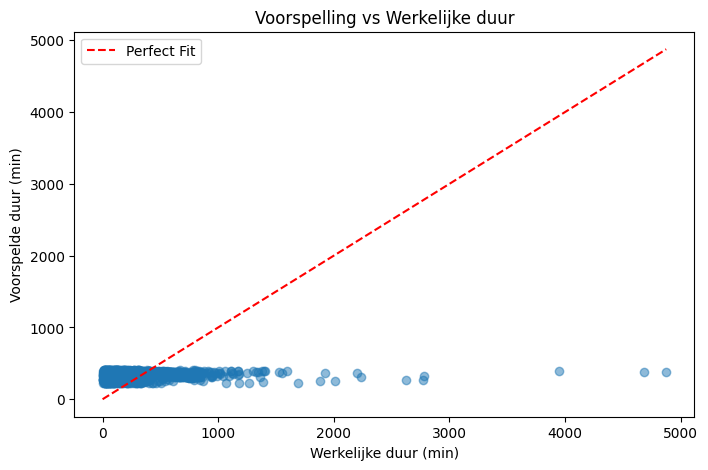

In [3]:
import subprocess
subprocess.check_call(["pip", "install", "tensorflow"])

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from scipy.special import gamma
from scipy.optimize import minimize

# 📌 Stap 1: Data inladen
df = pd.read_csv("acndata_sessions.csv")

# 📌 Stap 2: Data voorbereiden
df["connectionTime"] = pd.to_datetime(df["connectionTime"])
df["disconnectTime"] = pd.to_datetime(df["disconnectTime"])
df["duration"] = (df["disconnectTime"] - df["connectionTime"]).dt.total_seconds() / 60  # in minuten

# 📌 Stap 3: Feature Engineering
df["hour"] = df["connectionTime"].dt.hour  # Uur van de dag
df["weekday"] = df["connectionTime"].dt.weekday  # 0=maandag, 6=zondag
df["is_weekend"] = df["weekday"].apply(lambda x: 1 if x >= 5 else 0)  # Weekend indicator

# Selecteer relevante features
features = ["hour", "weekday", "is_weekend"]
X = df[features]
y = df["duration"]

# 📌 Stap 4: Train-test split en schaalverdeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 📌 Stap 5: Neuraal Netwerk (MLP) trainen
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu", input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1)  # Regressie-uitgang
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# 📌 Stap 6: Model evalueren
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} min, MSE: {mse:.2f}, R²: {r2:.2f}")

# 📌 Stap 7: Erlang-C Wachttijdmodel
def erlang_c(n, rho):
    """ Berekening van de gemiddelde wachttijd volgens het Erlang-C model """
    erlang = ( (n * rho) ** n / (np.math.factorial(n) * (1 - rho)) ) / (
        sum(( (n * rho) ** k / np.math.factorial(k) ) for k in range(n)) + ( (n * rho) ** n / (np.math.factorial(n) * (1 - rho)) )
    )
    return erlang / (n * (1 - rho))

# Simulatie van wachttijden
n_servers = 5  # Aantal laadpalen
arrival_rate = 10  # Aantal auto's per uur
service_rate = 1 / (y_train.mean() / 60)  # Gemiddelde servicetijd in uur

rho = arrival_rate / (n_servers * service_rate)
if rho < 1:
    wait_time = erlang_c(n_servers, rho) / service_rate
    print(f"Gemiddelde wachttijd volgens Erlang-C: {wait_time:.2f} uur")
else:
    print("Waarschuwing: Wachtrij niet stabiel (rho ≥ 1)")

# 📌 Stap 8: Visualisatie van modelprestaties
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, max(y_test)], [0, max(y_test)], "--", color="red", label="Perfect Fit")
plt.xlabel("Werkelijke duur (min)")
plt.ylabel("Voorspelde duur (min)")
plt.title("Voorspelling vs Werkelijke duur")
plt.legend()
plt.show()

In [4]:
#Test Huub